In [14]:
import os
import sys
import time
import argparse
import chainer
import chainer.links as L
import chainer.functions as F
import chainer.optimizers as optimizers
from chainer import cuda
import numpy as np
import cupy
import matplotlib.pyplot as plt
from IPython import display

import models
import nn
import data_utils

In [2]:
# static vars
#RNG_SEEDS     = [98765, 12345, 319, 77743196] # takes too long
#RNG_SEEDS     = [98765, 12345, 77743196] 
RNG_SEED = 77743196
BOUND         = 0.095
LEARNING_RATE = 0.01
GRAPH_CHANNELS = [6, 8, 16, 32, 16, 8, 3, 8, 16, 32, 16, 8, 3] # for graph model
SET_CHANNELS   = [6, 32, 128, 256, 128, 32, 256, 16, 3]
CHANNELS     = {0:SET_CHANNELS, 1:GRAPH_CHANNELS, 2:None}
NBODY_MODELS = {0:models.SetModel, 1:models.GraphModel, 2:models.VelocityScaled}
MTAGS        = {0:'S', 1:'G', 2:'V'}

In [3]:
#=============================================================================
# Training and model params
#=============================================================================
use_gpu = True
xp = cupy if use_gpu == 1 else np
mb_size   = 8 # 8
num_iters = 2000 # 3000
num_particles = 16
zX, zY = 0.4, 0.0
model_type = 1 # {0:set, 1:graph, 2:vel}
mtype  = NBODY_MODELS[model_type]
channels = CHANNELS[model_type]
mname  = ''
theta = None
use_theta = 0
save_label = data_utils.get_save_label(mname, MTAGS[model_type], use_theta, num_particles, zX, zY)
if use_theta == 1:
    thetas = np.load('./thetas_timesteps.npy').item()
    theta_val = thetas[(num_particles, zX, zY)]['W']
    theta = theta_val

model_dir = './testing/'
loss_path = model_dir + 'Loss/'
if not os.path.exists(loss_path): os.makedirs(loss_path)
    
def seed_rng(s=12345):
    np.random.seed(s)
    xp.random.seed(s)
seed_rng()
print('Training {}, save: {}'.format(save_label, model_dir))

Training G_16_0400_, save: ./testing/


In [4]:
#=============================================================================
# Load data
#=============================================================================
if (zX, zY) == (0.6, 0.0) and num_particles == 32:
    X = np.load('X32_0600.npy')
    Y = np.load('Y32_0600.npy')
else:
    X, Y = data_utils.load_data(num_particles, zX, zY, normalize_data=True)

if use_gpu:
    X = cuda.to_gpu(X)
    Y = cuda.to_gpu(Y)
X_tup, Y_tup = data_utils.split_data_validation(X,Y, num_val_samples=200)
X_train, X_val = X_tup
Y_train, Y_val = Y_tup
print('X_train.shape: {}'.format(X_train.shape))

X_train.shape: (800, 4096, 6)


In [5]:
#=============================================================================
# Loss history
#=============================================================================
train_loss_history = np.zeros((num_iters))
num_val_batches = X_val.shape[0] // mb_size
validation_loss_history = np.zeros((num_val_batches))

In [15]:
#=============================================================================
# Init model and opt
#=============================================================================
model_save_label = save_label + '{}_'.format(RNG_SEED)
print('model tag: {}'.format(model_save_label))
seed_rng(RNG_SEED)
model = mtype(channels, theta=theta)
if use_gpu: model.to_gpu()
optimizer = optimizers.Adam(alpha=LEARNING_RATE)
optimizer.setup(model)

model tag: G_16_0400_77743196_


KeyboardInterrupt: 

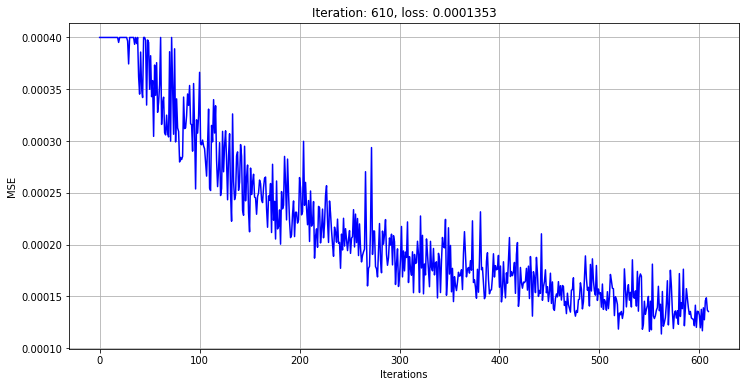

In [16]:
# train loop
for cur_iter in range(num_iters):
    model.zerograds() # must always zero grads before another forward pass!
    
    # create mini-batches for training
    _x_in, _x_true = data_utils.next_minibatch([X_train, Y_train], mb_size)
    x_in, x_true = chainer.Variable(_x_in), chainer.Variable(_x_true)
    
    # get prediction and loss
    x_hat = model(x_in, add=True) # prediction
    loss = nn.get_bounded_MSE(x_hat, x_true, boundary=BOUND) # bound = 0.095                
    #loss, loc_loss, vel_loss = nn.get_bounded_MSE_vel(x_hat, x_true, boundary=BOUND) # bound = 0.095
    
    # backprop and update
    loss.backward() # this calculates all the gradients (backprop)
    optimizer.update() # this updates the weights
    
    train_loss_history[cur_iter] = cuda.to_cpu(loss.data)
    if cur_iter % 10 == 0 and cur_iter != 0:
        y = train_loss_history[:cur_iter]
        plt.close('all')
        fig = data_utils.plot_training_curve(y, cur_iter, yclip=0.0004)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)

np.save(loss_path + save_label + 'train_loss', train_loss_history)
#print('{}: converged at {}'.format(model_save_label, np.median(lh_train[-150:])))
# save model, optimizer
data_utils.save_model([model, optimizer], model_dir + model_save_label)

In [22]:
# validation
with chainer.using_config('train', False):
    for val_iter in range(num_val_batches):
        j,k = val_iter * mb_size, (val_iter+1) * mb_size
        _val_in, _val_true = X_val[j:k], Y_val[j:k]
        val_in, val_true = chainer.Variable(_val_in), chainer.Variable(_val_true)
        
        val_hat  = model(val_in, add=True)
        val_loss = nn.mean_squared_error(val_hat, val_true, boundary=BOUND)
        validation_loss_history[val_iter] = cuda.to_cpu(val_loss.data)
        print('{:<3}: {:.8}'.format(val_iter, validation_loss_history[val_iter]))
    np.save(loss_path + save_label + 'val_loss', validation_loss_history)
    print('{}: validation avg {}'.format(model_save_label, np.mean(validation_loss_history)))

0  : 0.00013075116
1  : 0.00013182613
2  : 0.00011922169
3  : 0.00017336106
4  : 0.00012016048
5  : 0.00012035463
6  : 0.00012243852
7  : 0.00013374194
8  : 0.00010367872
9  : 0.00011797337
10 : 0.00012032747
11 : 0.00010863714
12 : 0.00014265404
13 : 0.00012265178
14 : 0.00013835019
15 : 0.00013226883
16 : 0.00013287264
17 : 0.00012656767
18 : 0.00014756095
19 : 0.00012954464
20 : 0.00011920968
21 : 0.00011802647
22 : 0.00013869027
23 : 0.0001281904
24 : 0.00012771031
G_16_0400_77743196_: validation avg 0.00012827080732677132


In [13]:
xh = cuda.to_cpu(x_hat.data)
xt = cuda.to_cpu(x_true.data)

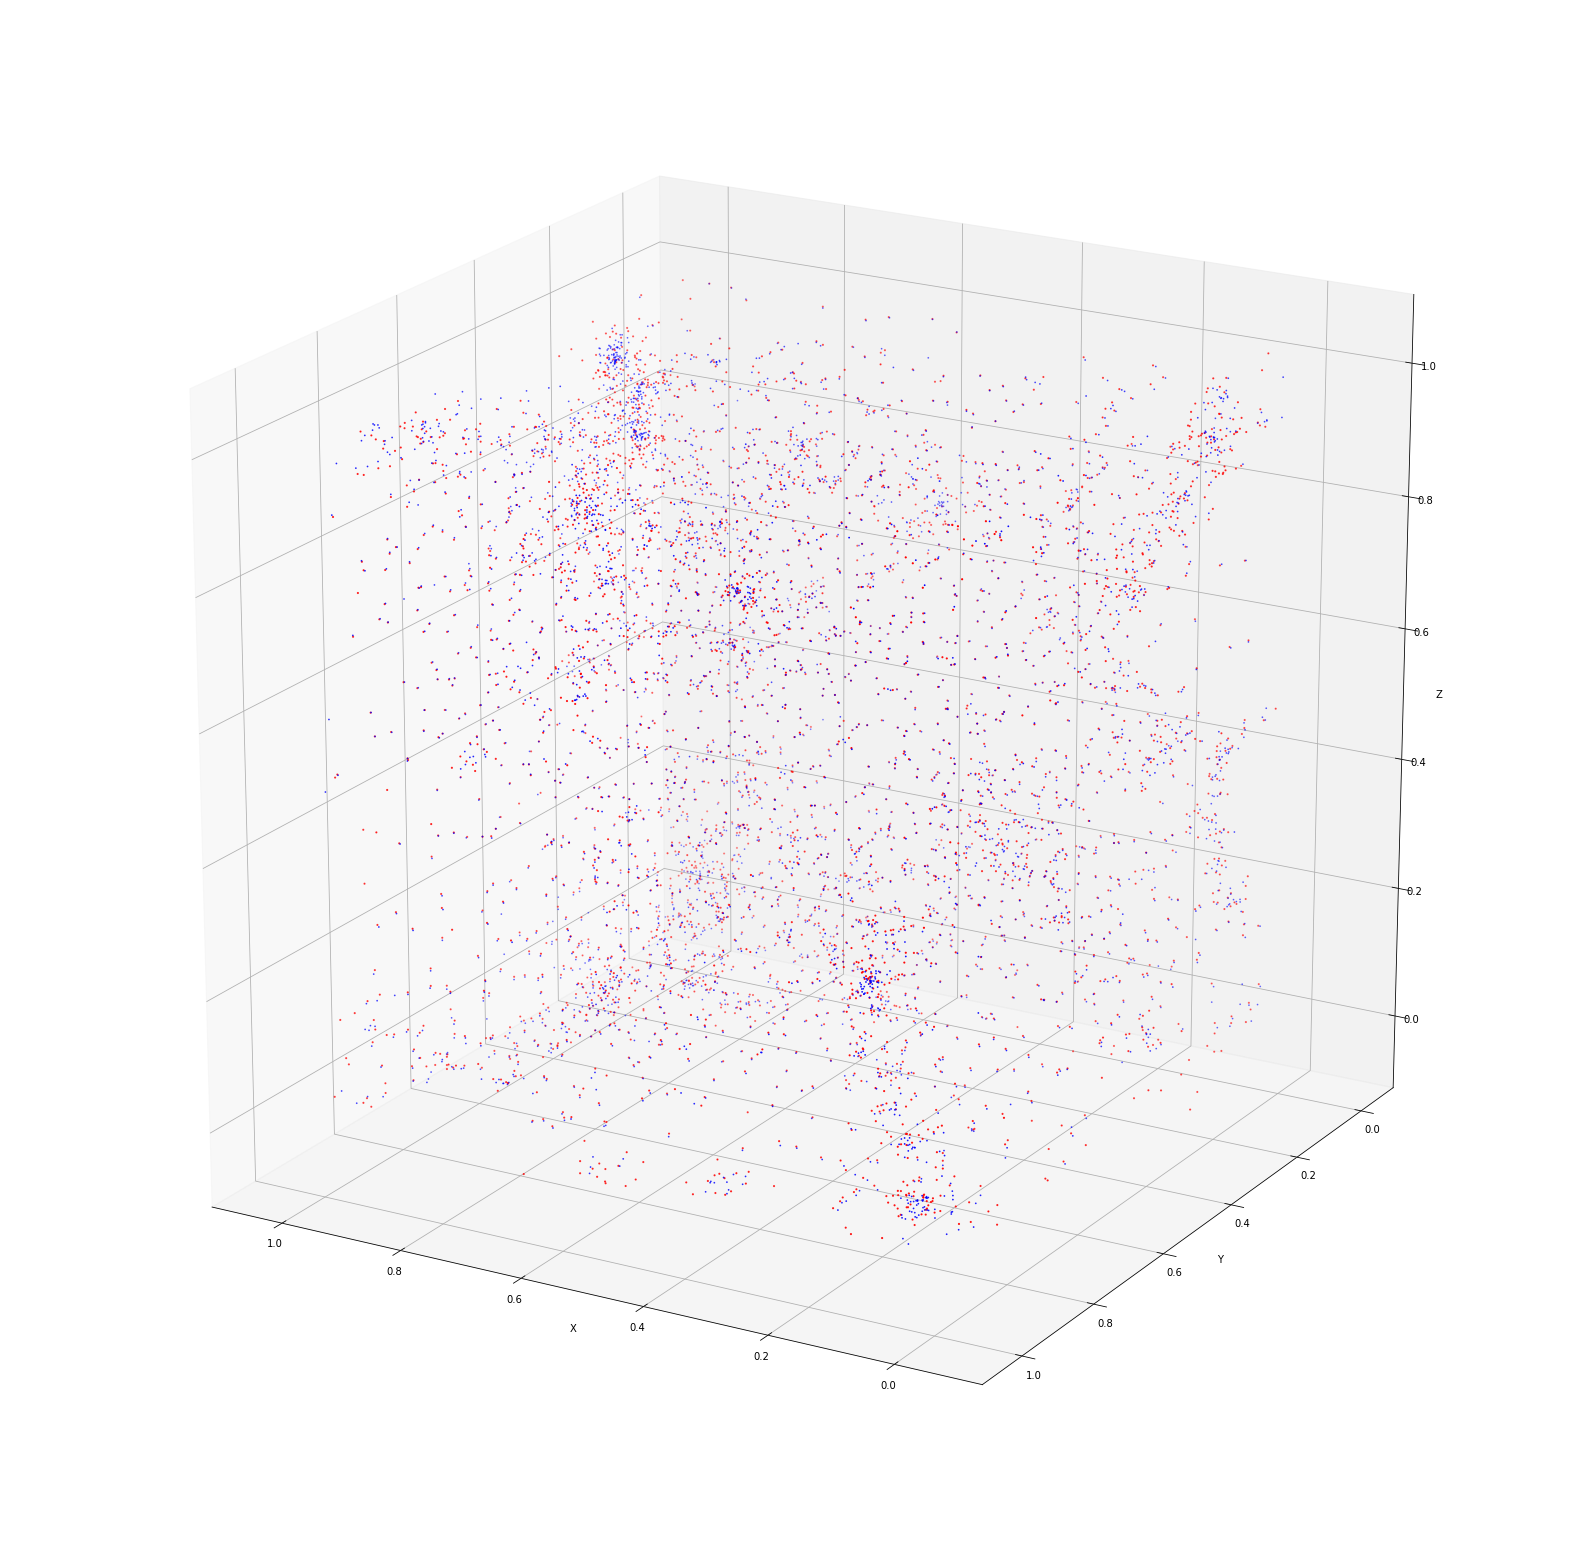

In [15]:
'''
plot point cloud
'''
from IPython import display
j = 3
fsize = (28,28)
particle_size = (.6, 1.3)
truth_color = 'blue'
pred_color = 'red'
colors = (truth_color, pred_color)

plt.close('all')
fig = data_utils.plot_3D_pointcloud(xt, xh, j, colors=colors, pt_size=particle_size, fsize=fsize)
plt.gca().view_init(20, 120)
display.display(plt.gcf())
display.clear_output(wait=True)
time.sleep(0.0001)
rotate = False
if rotate:
    for angle in range(0,360,40):
        fig.view_init(30, angle)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.0001)
#fig.savefig('./Plots/' + model_name, dpi=2400,bbox_inches='tight') # warning, this makes a huge image